In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

In [27]:
before_filelist = glob.glob('before_circulator/*')
after_filelist = glob.glob('after_circulator/*')

print(before_filelist)
print(after_filelist)

['before_circulator/20190502_0128_h_linear.dat', 'before_circulator/20190502_0129_v_linear.dat', 'before_circulator/20190502_0130_d_linear.dat', 'before_circulator/20190502_0131_a_linear.dat', 'before_circulator/20190502_0136_r_eliptical.dat']
['after_circulator/20190503_0242_l_eliptical.dat', 'after_circulator/20190503_0243_r_eliptical.dat', 'after_circulator/20190503_0244_h_linear.dat', 'after_circulator/20190503_0245_v_linear.dat', 'after_circulator/20190503_0246_d_linear.dat', 'after_circulator/20190503_0247_a_linear.dat']


In [28]:
"""
FITTING
"""
from lmfit import Model
from lmfit import Parameters
from lmfit.models import ConstantModel, QuadraticModel
from uncertainties import unumpy, ufloat

def hwp_osc(x, A, x_offset, period):
    x = x - x_offset
    return A * np.cos(np.pi / period * x)**2  # A * np.cos(np.pi / 90 * x)**2

def vis_fit(angle_range, sig):
    osc_model = Model(hwp_osc) + ConstantModel(prefix='bg_')
    p0 = Parameters()
    p0.add('A', np.max(sig) - np.min(sig), min=0, vary=True)
    p0.add('x_offset', angle_range[np.argmax(sig)], vary=True)
    p0.add('bg_c', np.min(sig), min=0, vary=True)
    p0.add('period', 90, vary=False)
    result = osc_model.fit(sig, x=angle_range, params=p0, weights=1/np.sqrt(sig), 
                           method='Powell')
#     amp = ufloat(result.params['A'].value, result.params['A'].stderr)
#     bkg = ufloat(result.params['bg_c'].value, result.params['bg_c'].stderr)
    amp = result.params['A'].value
    bkg = result.params['bg_c'].value
    visibility = amp / (amp + 2 * bkg)
    x_offset = result.params['x_offset'].value

    print ('v = {0:.5f}\n'.format(visibility) +
               'Cosine origin at: {0:.3f}'.format(x_offset))

    return visibility, x_offset, result

In [29]:
def extract_similar(phrase):
    before_file = before_filelist[np.where([phrase in fname for fname in before_filelist])[0][0]]
    after_file = after_filelist[np.where([phrase in fname for fname in after_filelist])[0][0]]
    
    print(before_file, after_file)
    
    angle_range, sig_before = np.loadtxt(before_file).T
    _, sig_after = np.loadtxt(after_file).T
    
    return angle_range, sig_before, sig_after

In [47]:
def extract_normalized(phrase):
    angles, before, after = extract_similar(phrase)
    print(before[:10])
    print(after[:10])
    _,_,result_before = vis_fit(angles, before)
    _,_,result_after = vis_fit(angles, after)
    
    a1,b1 = result_before.params["A"].value, result_before.params["bg_c"].value
    a2,b2 = result_after.params["A"].value, result_after.params["bg_c"].value
    
    x_offset = result_after.params["x_offset"].value
    x_offset_theoretical = ((x_offset+5)//22.5)*22.5
    
    print('x_offset supposed to be: {}'.format(x_offset_theoretical))
    
    n1 = (before-b1)/a1
    n2 = (after-b2)/a2
    
    theoretical = hwp_osc(angles, a1, x_offset_theoretical , 90) + b1
    
    return angles, before, n2*a1 + b1, theoretical

In [48]:
10//4

2

In [49]:
phrases = ['v_linear','d_linear','r_eliptical']

<IPython.core.display.Javascript object>


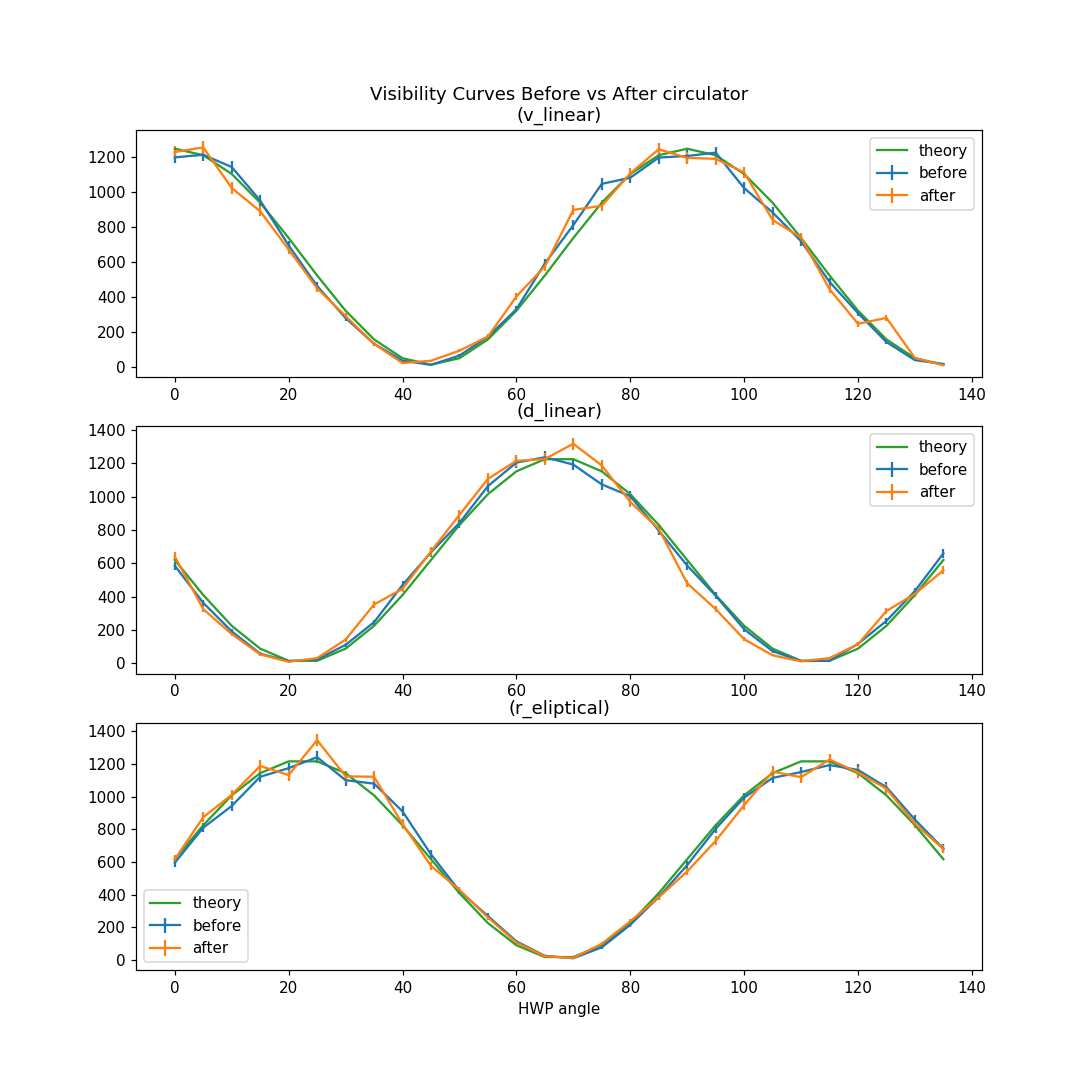

before_circulator/20190502_0129_v_linear.dat after_circulator/20190503_0245_v_linear.dat
[ 1195.  1210.  1140.   949.   693.   462.   279.   132.    36.    12.]
[ 470.  480.  391.  340.  256.  171.  110.   49.    7.   12.]
v = 0.97968
Cosine origin at: 89.134
v = 0.98640
Cosine origin at: -1.224
x_offset supposed to be: 0.0
before_circulator/20190502_0130_d_linear.dat after_circulator/20190503_0246_d_linear.dat
[ 586.  363.  192.   58.   13.   23.  111.  247.  470.  667.]
[ 234.  120.   66.   22.    6.   14.   54.  130.  164.  245.]
v = 0.99054
Cosine origin at: 66.656
v = 0.97897
Cosine origin at: 65.864
x_offset supposed to be: 67.5
before_circulator/20190502_0136_r_eliptical.dat after_circulator/20190503_0243_r_eliptical.dat
[  595.   810.   943.  1122.  1175.  1242.  1101.  1080.   910.   646.]
[ 231.  329.  381.  448.  427.  508.  424.  423.  313.  216.]
v = 0.98816
Cosine origin at: 23.378
v = 0.99729
Cosine origin at: 23.070
x_offset supposed to be: 22.5


In [69]:
%matplotlib notebook
plt.tight_layout
fig, ax = plt.subplots(3, figsize=(10,10))
title='Visibility Curves Before vs After circulator'
for i,phrase in enumerate(phrases):
    angles, before_normalized, after_normalized, theoretical = extract_normalized(phrase);
    ax[i].set_title((i==0)*title + '\n' + '(' + phrase + ')', horizontalalignment='center')
    ax[i].errorbar(angles, before_normalized, np.sqrt(before_normalized), label='before')
    ax[i].errorbar(angles, after_normalized, np.sqrt(after_normalized), label='after')
    ax[i].plot(angles, theoretical, label='theory')
    ax[i].legend()
ax[2].set_xlabel('HWP angle')
plt.savefig('before_after_circulator.pdf')
plt.show()

# PROGRAM TESTING

In [22]:
angles, before, after = extract_similar('eliptical')

IndexError: index 0 is out of bounds for axis 0 with size 0

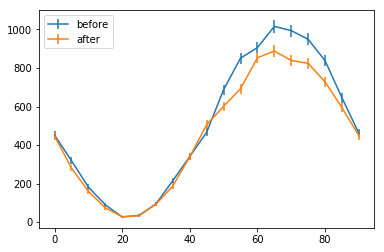

In [165]:
plt.figure()
plt.errorbar(angles, before, np.sqrt(before), label='before')
plt.errorbar(angles, after, np.sqrt(after), label='after')
plt.legend()
plt.show()

In [166]:
_, before_normalized, after_normalized = extract_normalized('eliptical');

v = 0.97331+/-0.02008
Cosine origin at: 67.161
v = 0.93556+/-0.01699
Cosine origin at: 67.120


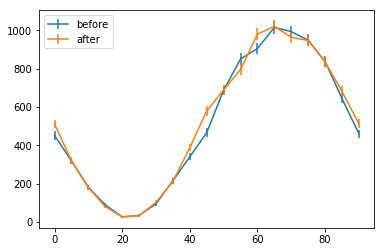

In [167]:
plt.figure()
plt.errorbar(angles, before_normalized, np.sqrt(before_normalized), label='before')
plt.errorbar(angles, after_normalized, np.sqrt(after_normalized), label='after')
plt.legend()
plt.show()